# Software Defect Prediction
#### An Exploration of Model Interpretability in Software Defect Analysis

`Aidan Goodyer (goodyera@mcmaster.ca)` `Mason Azzopardi (azzoparm@mcmaster.ca)`


___

### Imports and Dataset Loading

In [ ]:
%%capture
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import display, Markdown

df = pd.read_csv('dataset/dataset_csv/JM1.csv')

### Design Matrix and Label Construction, Standardization

We use ***z-score normalization*** to standardize our dataset so that we have a reliable scale to compare each metric against one and other.

Our design matrix is normalized as follows: 

$$ \phi(x) = \frac{x-\mu}{\sigma}$$

where:

$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i \hspace{5mm} \sigma = \sqrt{ \frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2} $$

with $x$ representing our individual raw features and the design matrix being the resulting matrix of $\phi(x)$ features.

In [ ]:
columns_dropped = [
    'LOC_BLANK', 'LOC_TOTAL', 'LOC_CODE_AND_COMMENT', # proxies for LOC
]

df = df.drop(columns = columns_dropped)

raw_features = df.iloc[:, :-1].values.astype(float)

X_all = np.log1p(df.iloc[:, :-1].values.astype(float))
y_all = df.iloc[:,-1].apply(lambda x: 1 if str(x) == 'Y' else 0).values


X, X_test, y, y_test = train_test_split(X_all,y_all, test_size=0.20, random_state=123, stratify=y_all)

mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)

X = (X-mu)/sigma
X_test = (X_test-mu)/sigma



# Model

The Logistic Regression approach we employ is defined below. 

---

### Gradients



We base our model on the Gradient Descent for Logistic Regression Algorithm described in the Lecture Note.



 $$  p(i) = \sigma( \theta^{t^\intercal} x^{(i)} + \theta_0) = \frac{1}{1+e^{- (\theta^{t^\intercal} x^{(i)} + \theta_0) }} $$


$$\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} (p^{(i)} - 1_{\{y^{(i)}=+1\}}) \mathbf{x}^{(i)} + \lambda \cdot \text{sign}(\boldsymbol{\theta}^{(t)})$$



$$\nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)}) = \frac{1}{n} \sum_{i=1}^{n} (p^{(i)} - 1_{\{y^{(i)}=+1\}})$$


Note since we are using **L1** Regularization, we have adjusted the gradient of the $\lambda$ term to be $\text{sign}(\boldsymbol{\theta}^{(t)})$ since $\frac{d}{dx} \left|x\right| = \text{sign}(x) $ 


---
### Update Rule 



Using these gradients, our update rule becomes: 

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$

$$\theta_0^{(t+1)} = \theta_0^{(t)} - \eta \nabla_{\theta_0}J(\boldsymbol{\theta}^{(t)}, \theta_0^{(t)})$$


---

The following python code implements the equations defined above:

In [ ]:
n, d = X.shape

eta = 0.1
theta = np.zeros(d)
theta_zero = 0 
l1_reg = 0.02
epochs = 1000

accuracy_v = [] # store accuracy 

def sigmoid(x):
    return 1/(1+np.exp(-x))


for i in range(epochs):
    z = np.dot(X,theta) + theta_zero
    p = sigmoid(z)

    predictions = (p>=0.3).astype(int)
    accuracy = np.mean(predictions==y)
    accuracy_v.append(accuracy)


    error = p-y

    asymmetric_error = np.where(y==1, error*4, error)

    d_theta = (1/n)*np.dot(X.T, asymmetric_error) + l1_reg*np.sign(theta)
    d_theta_zero = (1/n)*np.sum(p-y)

    theta -= eta*d_theta
    theta_zero -= eta*d_theta_zero

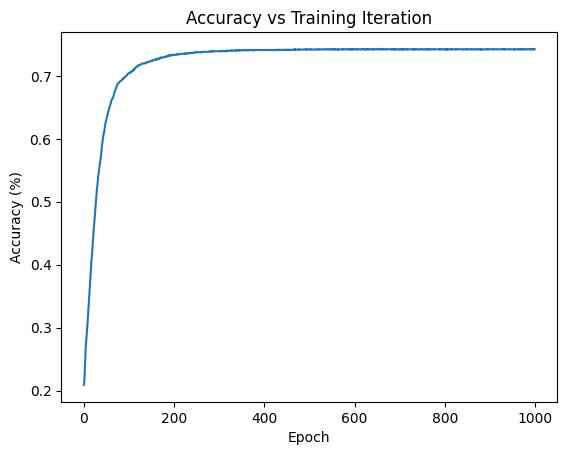

In [ ]:
# Plot Accuracy
plt.plot(accuracy_v, label='Training Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy vs Training Iteration')
plt.show()

## Results Analysis
--- 

#### Confusion Matrices: 

In [ ]:
# ~~~~~~~~~~~~~~ Training Set Results ~~~~~~~~~~~~~~

true_positives = np.sum( (predictions==1) & (y==1))
true_negatives = np.sum( (predictions==0) & (y==0))
false_positives = np.sum( (predictions==1) & (y==0))
false_negatives = np.sum( (predictions==0) & (y==1))

md_table = '### Confusion Matrix: Training Set\n'
md_table += '| | Predicted: Correct (0) | Predicted: Defect (1) |\n'
md_table += '| :--- | :---: | :---: |\n'
md_table += f'| **Actual: Clean (0)** | {true_negatives} (True Negative) | {false_positives} (False Positive) |\n'
md_table += f'| **Actual: Buggy (1)** | {false_negatives} (False Negative) | {true_positives} (True Positive) |\n'
display(Markdown(md_table))

# ~~~~~~~~~~~~~~ Test Set Results ~~~~~~~~~~~~~~

z_test = np.dot(X_test,theta) + theta_zero
p_test = sigmoid(z_test)
y_pred = (p_test >= 0.3).astype(int)


true_positives_test = np.sum( (y_pred==1) & (y_test==1))
true_negatives_test  = np.sum( (y_pred==0) & (y_test==0))
false_positives_test  = np.sum( (y_pred==1) & (y_test==0))
false_negatives_test  = np.sum( (y_pred==0) & (y_test==1))

md_table = '### Confusion Matrix: Test Set\n'
md_table += '| | Predicted: Correct (0) | Predicted: Defect (1) |\n'
md_table += '| :--- | :---: | :---: |\n'
md_table += f'| **Actual: Clean (0)** | {true_negatives_test} (True Negative) | {false_positives_test} (False Positive) |\n'
md_table += f'| **Actual: Buggy (1)** | {false_negatives_test} (False Negative) | {true_positives_test} (True Positive) |\n'


display(Markdown(md_table))

### Confusion Matrix: Training Set
| | Predicted: Correct (0) | Predicted: Defect (1) |
| :--- | :---: | :---: |
| **Actual: Clean (0)** | 4018 (True Negative) | 868 (False Positive) |
| **Actual: Buggy (1)** | 722 (False Negative) | 568 (True Positive) |


### Confusion Matrix: Test Set
| | Predicted: Correct (0) | Predicted: Defect (1) |
| :--- | :---: | :---: |
| **Actual: Clean (0)** | 992 (True Negative) | 230 (False Positive) |
| **Actual: Buggy (1)** | 181 (False Negative) | 141 (True Positive) |


### Feature Importance for Defect Prediction 
Metric Name | Weight Magnitude | Impact 
 | :--- | :--- | :--- 
| NUM_UNIQUE_OPERANDS | 0.4293 | ⬆ Probability
| LOC_EXECUTABLE | 0.3802 | ⬆ Probability
| NUM_UNIQUE_OPERATORS | 0.1889 | ⬆ Probability
| BRANCH_COUNT | 0.1463 | ⬆ Probability
| HALSTEAD_CONTENT | 0.1390 | ⬆ Probability
| LOC_COMMENTS | 0.1095 | ⬆ Probability
| HALSTEAD_ERROR_EST | 0.0150 | ⬇ Probability
| HALSTEAD_VOLUME | 0.0025 | ✖ Little Impact
| HALSTEAD_EFFORT | 0.0025 | ✖ Little Impact
| NUM_OPERANDS | 0.0021 | ✖ Little Impact
| HALSTEAD_DIFFICULTY | 0.0018 | ✖ Little Impact
| CYCLOMATIC_COMPLEXITY | 0.0018 | ✖ Little Impact
| DESIGN_COMPLEXITY | 0.0011 | ✖ Little Impact
| HALSTEAD_PROG_TIME | 0.0010 | ✖ Little Impact
| HALSTEAD_LENGTH | 0.0009 | ✖ Little Impact
| HALSTEAD_LEVEL | 0.0005 | ✖ Little Impact
| NUM_OPERATORS | 0.0003 | ✖ Little Impact
| ESSENTIAL_COMPLEXITY | 0.0003 | ✖ Little Impact


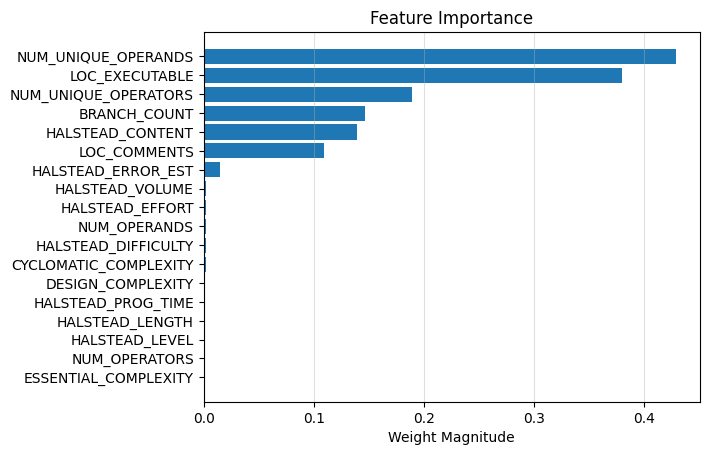

In [ ]:
md_table = '### Feature Importance for Defect Prediction \n'
md_table += 'Metric Name | Weight Magnitude | Impact \n'
md_table += ' | :--- | :--- | :--- \n'

feature_names = df.columns[:-1]
importance = sorted(list(zip(feature_names,abs(theta),np.sign(theta))), key=lambda x: abs(x[1]), reverse=True)

for name, weight, sign in importance :

    impact = '✖ Little Impact' if (weight < 1e-2) else ('⬆ Probability' if sign>0 else '⬇ Probability')
    md_table += f"| {name} | {weight:.4f} | {impact}\n"

display(Markdown(md_table))


names = [name for name, _, _ in importance]
weight = [ weight for _, weight, _ in importance]


plt.title('Feature Importance')
plt.xlabel("Weight Magnitude")
plt.grid(axis='x', alpha=0.4)
plt.barh(names[::-1],weight[::-1])
plt.show()

